# <div style="font-family: 'Playfair Display', serif; font-weight:bold; letter-spacing: 0px; color:#FAF0EF; font-size:150%; text-align:center; padding:10px; background: #1db5baff; border-radius: 10px; box-shadow: 10px 10px 5px #7abcafff;">🌟   <br></div>

In [2]:
import kagglehub
import pandas as pd
import os

# Download dataset to cache (not project folder)
path = kagglehub.dataset_download("justinas/startup-investments")

# List files to know the exact CSV name
os.listdir(path)


100%|██████████| 115M/115M [01:08<00:00, 1.75MB/s] 

Extracting files...


['acquisitions.csv',
 'degrees.csv',
 'funding_rounds.csv',
 'funds.csv',
 'investments.csv',
 'ipos.csv',
 'milestones.csv',
 'objects.csv',
 'offices.csv',
 'people.csv',
 'relationships.csv']

In [12]:
import pandas as pd
import os

objects = pd.read_csv(os.path.join(path, "objects.csv"))
funding = pd.read_csv(os.path.join(path, "funding_rounds.csv"))
investments = pd.read_csv(os.path.join(path, "investments.csv"))
ipos = pd.read_csv(os.path.join(path, "ipos.csv"))
acq = pd.read_csv(os.path.join(path, "acquisitions.csv"))
offices = pd.read_csv(os.path.join(path, "offices.csv"))




C:\Users\Amira\AppData\Local\Temp\ipykernel_6912\3778030081.py:4: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects = pd.read_csv(os.path.join(path, "objects.csv"))


In [13]:
companies = objects[objects["entity_type"] == "Company"].copy()


MERGE 1 — Funding

In [15]:
funding.columns


Index(['id', 'funding_round_id', 'object_id', 'funded_at',
       'funding_round_type', 'funding_round_code', 'raised_amount_usd',
       'raised_amount', 'raised_currency_code', 'pre_money_valuation_usd',
       'pre_money_valuation', 'pre_money_currency_code',
       'post_money_valuation_usd', 'post_money_valuation',
       'post_money_currency_code', 'participants', 'is_first_round',
       'is_last_round', 'source_url', 'source_description', 'created_by',
       'created_at', 'updated_at'],
      dtype='object')

In [19]:
funding_agg = funding.groupby("object_id").agg(
    total_funding_usd=("raised_amount_usd", "sum"),
    nb_funding_rounds=("funding_round_id", "count")
).reset_index()

companies = companies.merge(
    funding_agg,
    left_on="id",       # ← id من companies
    right_on="object_id",
    how="left"
)

# NaN → 0
companies["total_funding_usd"] = companies["total_funding_usd"].fillna(0)
companies["nb_funding_rounds"] = companies["nb_funding_rounds"].fillna(0)




Investments

In [21]:
investments.columns


Index(['id', 'funding_round_id', 'funded_object_id', 'investor_object_id',
       'created_at', 'updated_at'],
      dtype='object')

In [23]:
investor_agg = investments.groupby("funded_object_id").agg(
    nb_investors=("investor_object_id", "nunique")
).reset_index()

companies = companies.merge(
    investor_agg,
    left_on="id",               # id من companies
    right_on="funded_object_id",  # العمود الصحيح من investments
    how="left"
)


companies["nb_investors"] = companies["nb_investors"].fillna(0)


IPO

In [ ]:
ipos["ipo"] = 1   
ipos = ipos.rename(columns={"object_id": "company_object_id"})

companies = companies.merge(
    ipos[["company_object_id", "ipo"]],
    left_on="id",
    right_on="company_object_id",
    how="left"
)

companies["ipo"] = companies["ipo"].fillna(0)


Acquisitions

In [25]:
acq["acquired"] = 1
acq = acq.rename(columns={"acquired_object_id": "company_object_id"})

companies = companies.merge(
    acq[["company_object_id", "acquired"]],
    left_on="id",
    right_on="company_object_id",
    how="left"
)

companies["acquired"] = companies["acquired"].fillna(0)


Offices

In [26]:
office_agg = offices.groupby("object_id").agg(
    nb_offices=("office_id", "count"),
    country=("country_code", "first")
).reset_index().rename(columns={"object_id": "company_object_id"})

companies = companies.merge(
    office_agg,
    left_on="id",
    right_on="company_object_id",
    how="left"
)

companies["nb_offices"] = companies["nb_offices"].fillna(0)
companies["country"] = companies["country"].fillna("Unknown")


In [28]:
companies.shape
 


(196704, 52)

In [29]:
 
companies.head()


,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,nb_funding_rounds,funded_object_id,nb_investors,company_object_id_x,ipo,company_object_id_y,acquired,company_object_id,nb_offices,country
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,3.0,c:1,4.0,NaN,0.0,NaN,0.0,c:1,2.0,USA
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,0.0,NaN,0.0,NaN,0.0,c:10,1.0,c:10,1.0,USA
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,0.0,NaN,0.0,NaN,0.0,c:100,1.0,c:100,1.0,USA
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,Unknown
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,Unknown


# Visualisation

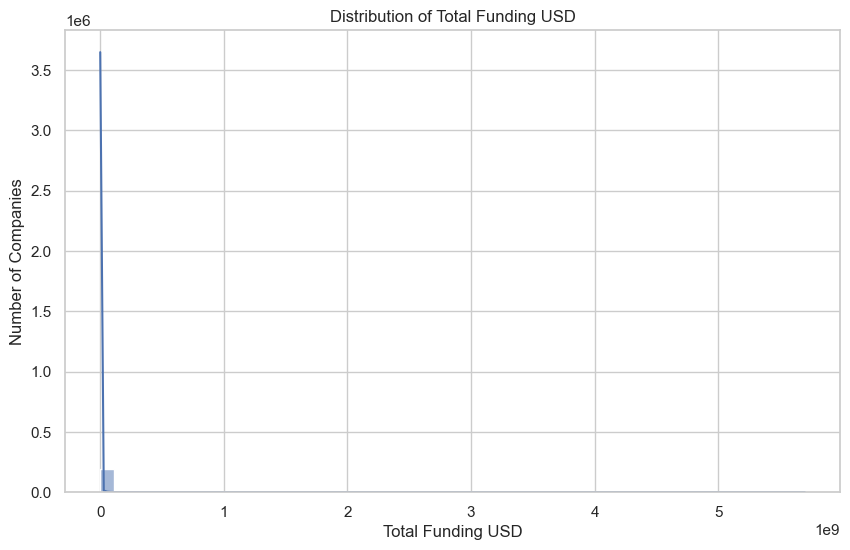

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Set style for plots
sns.set(style="whitegrid")

# 2️⃣ Plot total funding distribution
plt.figure(figsize=(10,6))
sns.histplot(companies["total_funding_usd"], bins=50, kde=True)
plt.title("Distribution of Total Funding USD")  # title of plot
plt.xlabel("Total Funding USD")                  # x-axis label
plt.ylabel("Number of Companies")                # y-axis label
plt.show()


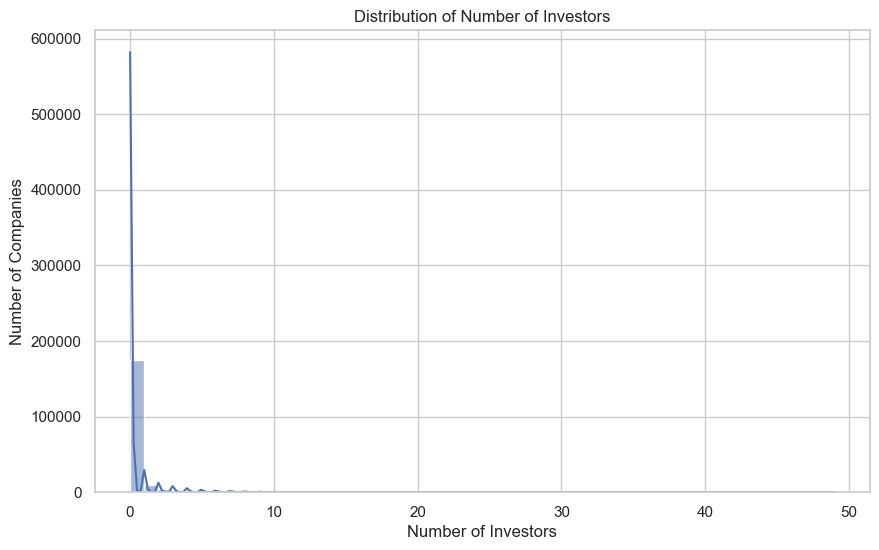

In [31]:

# 3️⃣ Plot number of investors distribution
plt.figure(figsize=(10,6))
sns.histplot(companies["nb_investors"], bins=50, kde=True)
plt.title("Distribution of Number of Investors")
plt.xlabel("Number of Investors")
plt.ylabel("Number of Companies")
plt.show()



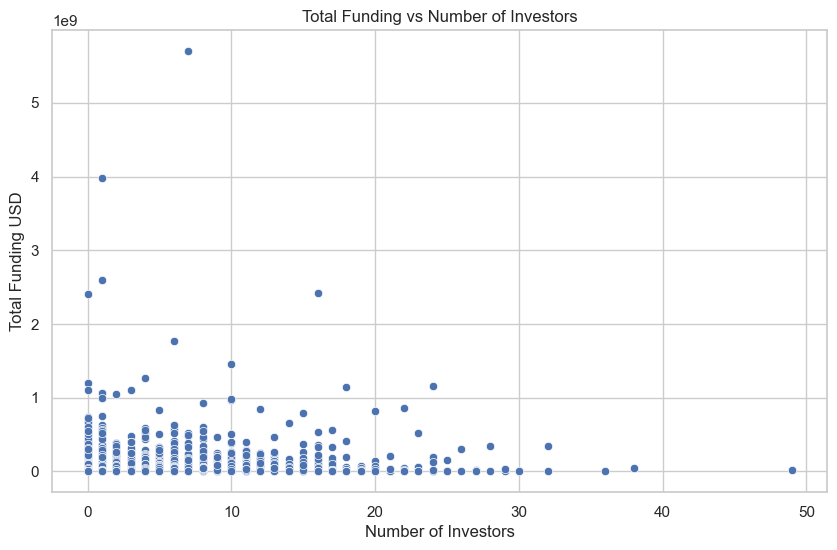

In [32]:
# 4️⃣ Scatter plot: total funding vs number of investors
plt.figure(figsize=(10,6))
sns.scatterplot(x="nb_investors", y="total_funding_usd", data=companies)
plt.title("Total Funding vs Number of Investors")
plt.xlabel("Number of Investors")
plt.ylabel("Total Funding USD")
plt.show()


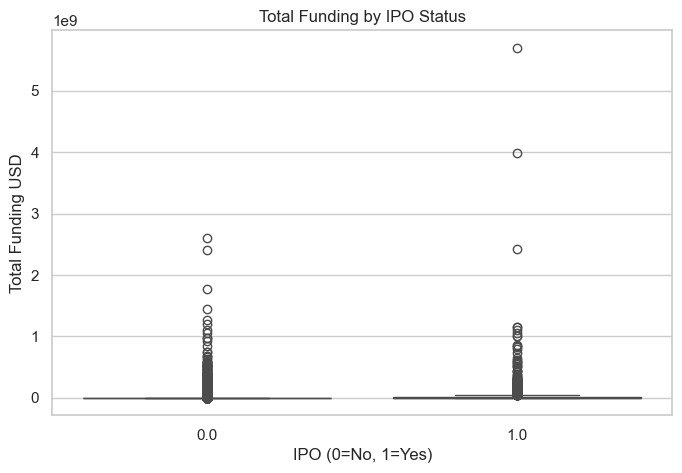

In [33]:
# 1️⃣ Total Funding by IPO status
plt.figure(figsize=(8,5))
sns.boxplot(x="ipo", y="total_funding_usd", data=companies)
plt.title("Total Funding by IPO Status")   # title
plt.xlabel("IPO (0=No, 1=Yes)")           # x-axis label
plt.ylabel("Total Funding USD")            # y-axis label
plt.show()




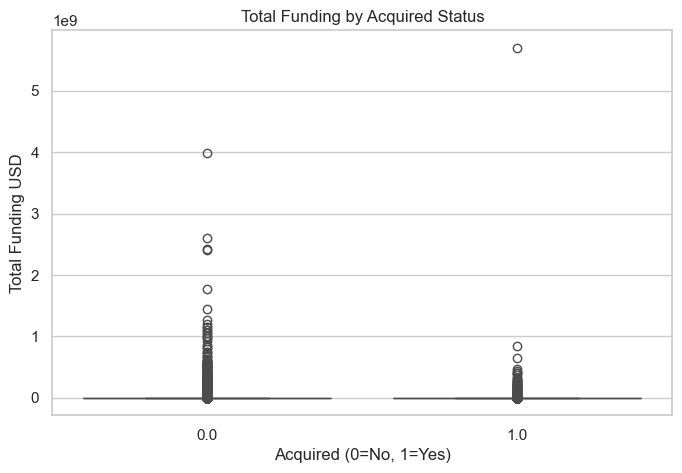

In [34]:
# 2️⃣ Total Funding by Acquired status
plt.figure(figsize=(8,5))
sns.boxplot(x="acquired", y="total_funding_usd", data=companies)
plt.title("Total Funding by Acquired Status")
plt.xlabel("Acquired (0=No, 1=Yes)")
plt.ylabel("Total Funding USD")
plt.show()



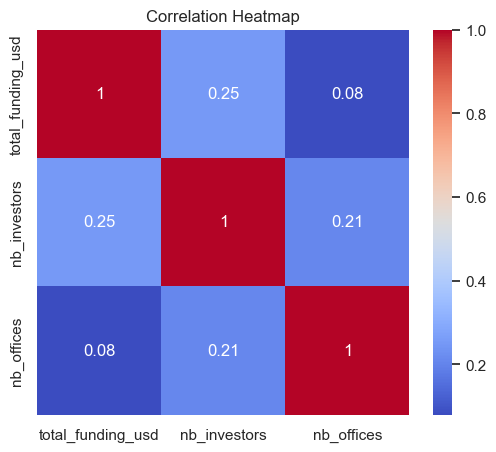

In [35]:
# 3️⃣ Correlation heatmap
# Select numeric columns for correlation
numeric_cols = ["total_funding_usd", "nb_investors", "nb_offices"]

corr = companies[numeric_cols].corr()  # calculate correlation

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

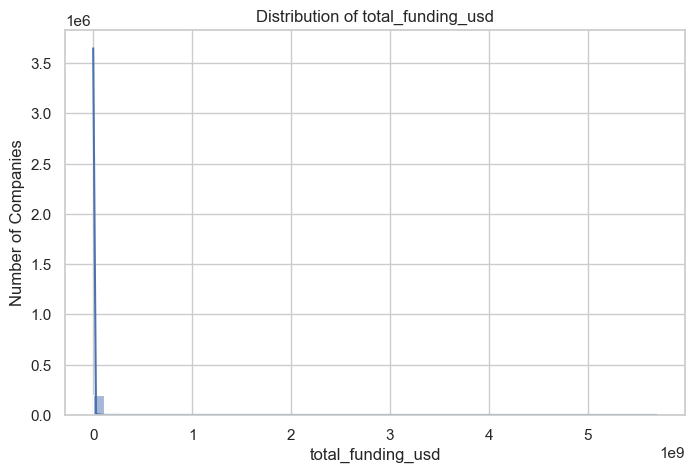

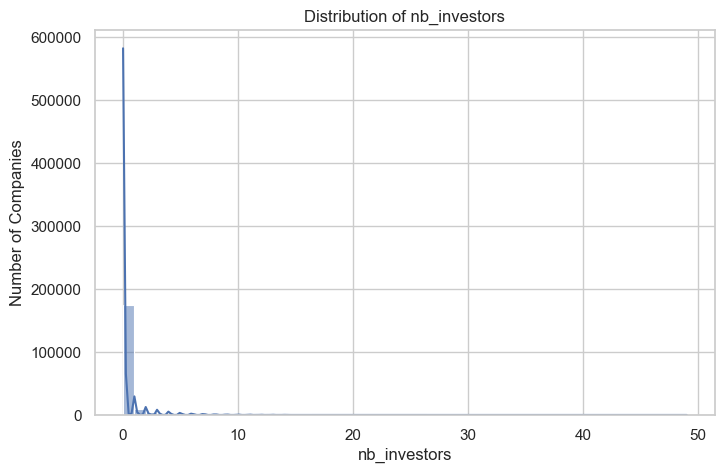

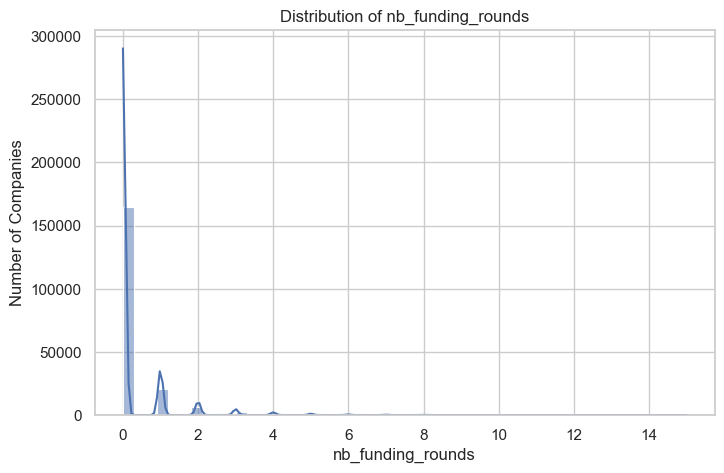

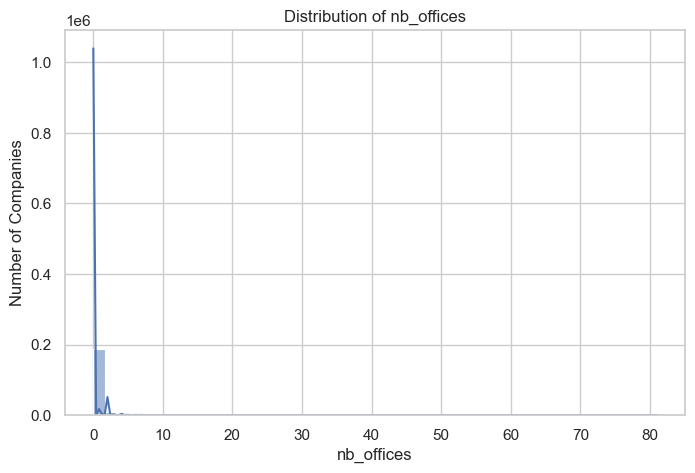

In [36]:
# 1️⃣ List of numeric features
numeric_features = ["total_funding_usd", "nb_investors", "nb_funding_rounds", "nb_offices"]

# 2️⃣ Plot distribution for each numeric feature
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

for feature in numeric_features:
    plt.figure(figsize=(8,5))
    sns.histplot(companies[feature], bins=50, kde=True)  # histogram + density
    plt.title(f"Distribution of {feature}")             # plot title
    plt.xlabel(feature)                                 # x-axis label
    plt.ylabel("Number of Companies")                  # y-axis label
    plt.show()
